In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity.tsv', sep='\t', on_bad_lines='skip')
data_detail = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_student_activity_detail.tsv', sep='\t',on_bad_lines='skip')
data_assessment = pd.read_csv('/Users/rachel/Library/CloudStorage/Dropbox-TLPSummerInterns/TLP Summer Intern Folder/Zhou/CODE - MPS_data_july_2023/mps_assessments.tsv', sep='\t', on_bad_lines='skip')
data_assessment['school_year'] = data_assessment['script_name'].str[-4:]

# 5.3 Predicting Assessment Performance

1. **Feature Engineering**: Created new features `implementation_level`, `first_year_of_teaching`, `child_level_type`, and learning profile labels. 

2. **Model Training and Evaluation**: Leveraged linear regression and machine learning techniqes to predict student assessment scores. Calculated the MSE and R-sQUARED to evaluate the performance of the model.

3. **Feature Importance Analysis**: Interpreted the feature importance of the models to understand the relationship between the predictors and the target variable.


## Feature Engineering

Three features were generated from the raw data:

{code}`implementation_level`: Categorized teachers into 3 levels (low, medium, high) based on their cumulative activity over time using K-Means clustering. This helps differentiate teachers based on their experience levels.

{code}`first_year_of_teaching`: Indicated whether a teacher is teaching a particular course for the first time. This captures how teacher proficiency changes over time.

{code}`child_level_type`: Rpepresented the quiz item type, can be Multi (single-select multi choice), Multi2 (choose-two multi-choice), and Match (matching items)

### Teacher Implementation Level Clustering

This {code}`cluster_teachers_by_implementation` function processes data from activity dataset to categorize teachers based on their cumulative implementation levels over various school years. 

The implementation levels are determined by metrics such as the cumulative unique number of scripts assigned and the cumulative unique number of students they've interacted with up to a particular school year.

In [62]:
def compute_cumulative_unique(series):
    cumulative_list = []
    seen = set()
    for s in series:
        seen.update(s)
        cumulative_list.append(len(seen))
    return cumulative_list

def cluster_teachers_by_implementation(data):
    # Step 1: Preprocess the Data
    data_sorted = data.sort_values(by=['teacher_user_id', 'school_year'])

    # Step 2: Compute cumulative unique values for scripts and students
    cumulative_data = data_sorted.groupby(['teacher_user_id', 'school_year']).agg({
        'script_id': 'unique',
        'student_user_id': 'unique'
    }).reset_index()
    cumulative_data['cumulative_scripts'] = cumulative_data.groupby('teacher_user_id')['script_id'].transform(compute_cumulative_unique)
    cumulative_data['cumulative_students'] = cumulative_data.groupby('teacher_user_id')['student_user_id'].transform(compute_cumulative_unique)

    # Step 3: Scale the Metrics
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cumulative_data[['cumulative_scripts', 'cumulative_students']])

    # Step 4: Apply KMeans Clustering
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    cumulative_data['cluster_id'] = kmeans.fit_predict(scaled_data)

    # Step 5: Convert cluster IDs to labels
    cluster_labels = {0: 'Low', 2: 'Medium', 1: 'High'}
    cumulative_data['implementation_level'] = cumulative_data['cluster_id'].map(cluster_labels)
    cluster_membership_df = cumulative_data[['teacher_user_id', 'school_year', 'implementation_level']]
    cluster_membership_df['school_year'] = cluster_membership_df['school_year'].str[:4]
    
    return cluster_membership_df

implementation = cluster_teachers_by_implementation(data)
df_merged = pd.merge(data_assessment, implementation, on=['teacher_user_id', 'school_year'], how='left')

### Question Type and Teacher Experience Features

Previous descriptive analysis on assessment dataset has shown that correctness vary on course and question type, so here we extracted the feature {code}`child_level_type` to control for its impact.

In [64]:
# Calculate the difficulty coefficient for each course and parent level
difficulty_coefficients = data_assessment.groupby(['course_name', 'parent_level_type','child_level_type'])['answer_correct_flag'].apply(lambda x: (x == 'Y').mean()).reset_index()
difficulty_coefficients.columns = ['course_name', 'parent_level_type','child_level_type', 'difficulty_coefficient']
df_merged = pd.merge(df_merged, difficulty_coefficients, on=['course_name','parent_level_type','child_level_type',], how='left')

# Calculate the first year each teacher taught this course
first_year_taught = df_merged.groupby('teacher_user_id')['school_year'].min().reset_index()
first_year_taught.columns = ['teacher_user_id', 'first_year_taught']
df_merged = pd.merge(df_merged, first_year_taught, on='teacher_user_id', how='left')
# Create a new column to indicate whether the current year is the first year the teacher taught this course
df_merged['first_year_of_teaching'] = (df_merged['school_year'] == df_merged['first_year_taught']).astype(int) #1 represents is first year

# Replace 'Y' and 'N' in 'answer_correct_flag' with 1 and 0 respectively
df_merged['answer_correct_flag'] = df_merged['answer_correct_flag'].map({'Y': 1, 'N': 0})
df_model = df_merged[['teacher_user_id','course_name','school_year','parent_level_type','child_level_type','student_user_id','implementation_level','difficulty_coefficient','first_year_of_teaching','answer_correct_flag']]
df_model['difficulty_coefficient'] = 1 - df_model['difficulty_coefficient']

### Student Learning Behavior Features

In [67]:
# Calculating the time gap between created_at and updated_at timestamps
data_detail['created_at'] = pd.to_datetime(data_detail['created_at'])
data_detail['updated_at'] = pd.to_datetime(data_detail['updated_at'])
data_detail['time_gap'] = (data_detail['updated_at'] - data_detail['created_at']).dt.total_seconds() 
# Filtering the data based on the given criteria
filtered_data = data_detail[(data_detail['attempts'] != 0) & 
                     (data_detail['time_gap'] >= 0) & 
                     (data_detail['time_gap'] <= 60*15)]

# Categorizing the test results based on provided breakdown
def categorize_test_result(result):
    if result < 20 and result != -1:
        return 'Failed'
    elif 20 <= result < 30:
        return 'Pass (Not Optimal)'
    elif 30 <= result < 1000:
        return 'Optimal'
    else:
        return 'Special'

filtered_data['test_result_category'] =filtered_data['best_result'].apply(categorize_test_result)

# Identify Learning Behaviors for the filtered data
def assign_behavior_label(row):
    if (row['attempts'] == 1) and (row['test_result_category'] == 'Failed'):
        return "One-shot Failures"
    elif (row['attempts'] > 2) and (row['test_result_category'] == 'Failed'):
        return "Strugglers"
    elif row['test_result_category'] == 'Pass (Not Optimal)':
        return "Suboptimal Success"
    elif (row['attempts'] == 1) and (row['test_result_category'] == 'Optimal'):
        return "Succeed at First Trial"
    elif (row['attempts'] > 1) and (row['time_gap'] < 10) and (row['test_result_category'] == 'Optimal'):
        return "Rapid Guessing"
    elif (row['attempts'] > 1) and (row['time_gap'] > 30) and (row['test_result_category'] == 'Optimal'):
        return "Reflective Learner"
    else:
        return "Others"
    
filtered_data['behavior_label'] = filtered_data.apply(assign_behavior_label, axis=1)

# Counting occurrences of each label
behavior_counts = filtered_data['behavior_label'].value_counts()

# convert counts to proportion to standardize the data
grouped_data = filtered_data.groupby(['student_user_id', 'school_year', 'behavior_label']).size().unstack().reset_index().fillna(0)
grouped_data.iloc[:, 2:] = grouped_data.iloc[:, 2:].div(grouped_data.iloc[:, 2:].sum(axis=1), axis=0)

# Standardizing the data
scaler = StandardScaler()
grouped_data.iloc[:, 2:] = scaler.fit_transform(grouped_data.iloc[:, 2:])
grouped_data['school_year'] = grouped_data['school_year'].str[:4]

In [68]:
df_model = pd.merge(df_model, grouped_data, on=['student_user_id','school_year'], how='left')
df_model.head()

,teacher_user_id,course_name,school_year,parent_level_type,child_level_type,student_user_id,implementation_level,difficulty_coefficient,first_year_of_teaching,answer_correct_flag,One-shot Failures,Others,Rapid Guessing,Reflective Learner,Strugglers,Suboptimal Success,Succeed at First Trial
0,24529224,csd,2017,Gamelab,Multi,33728229,High,0.64523,1,0.0,0.974118,-0.507336,0.084512,-0.932389,-0.423593,-0.456561,0.692087
1,24529224,csd,2017,Gamelab,Multi,33718947,High,0.64523,1,1.0,-0.277267,-0.486426,-0.332095,-0.994872,0.679608,-0.456561,0.896996
2,24529224,csd,2017,Gamelab,Multi,29432841,High,0.64523,1,0.0,0.861267,-0.176840,0.382254,-0.711923,-0.465862,-0.456561,0.414940
3,24529224,csd,2017,Gamelab,Multi,33752236,High,0.64523,1,0.0,0.325929,-0.025362,-0.415028,-0.860324,-0.419108,-0.456561,0.780722
4,24529224,csd,2017,Gamelab,Multi,33752305,High,0.64523,1,0.0,0.341637,0.066355,-0.508779,-0.879053,-0.252751,-0.456561,0.706011


## Model Training and Evaluation

1. Split the data into training and testing sets.

2. Train Linear Regression, Random Forest, Gradient Boosting, and SVR models.

3. Evaluate the models on the test set using metrics like MAE, MS, RMSE and ROC AUC.

### Model Selection

| Model                         | Description                                                                                                 | Characteristics                                                                                               | Reason to be Chosen in Our Dataset                                                                                                           |
|-------------------------------|-------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| **Linear Regression**         | Models the linear relationship between independent and dependent variables.                                 | **Advantages**: Simple and interpretable; Fast to train.<br>**Disadvantages**: Assumes linear relationships; Sensitive to outliers.          | **Why Chosen**: Foundational algorithm for regression tasks.<br>**Relevance**: Provides baseline performance and initial insight into linear relationships in the dataset.                           |
| **Random Forest Regressor**   | Ensemble of decision trees to improve accuracy and control overfitting.                                     | **Advantages**: Can handle linear and non-linear data; Less prone to overfitting; Robust to outliers.<br>**Disadvantages**: Can be computationally expensive for large datasets.          | **Why Chosen**: Versatile and robust model.<br>**Relevance**: Captures complex interactions and offers insight into feature importance, making it suitable for datasets with mixed features.          |
| **Gradient Boosting Regressor** | Boosting technique building trees sequentially, each correcting its predecessor's errors.                  | **Advantages**: High predictive accuracy; Can capture subtle patterns.<br>**Disadvantages**: Requires careful tuning; More prone to overfitting with noisy data.                | **Why Chosen**: Known for high accuracy in various applications.<br>**Relevance**: Suitable for capturing intricate patterns and relationships in the dataset when tuned correctly. |
| **Support Vector Regression (SVR)** | Finds the best hyperplane to predict continuous values; Can handle high dimensional spaces.              | **Advantages**: Effective in high-dimensional spaces; Can model non-linear relationships.<br>**Disadvantages**: Requires data scaling; Choice of kernel and parameters crucial.     | **Why Chosen**: Effective for potential non-linear relationships.<br>**Relevance**: Given the diverse nature of the dataset, SVR can model non-linear patterns when using the appropriate kernel.     |


In [71]:
"""
### Use child_level_type
data_cleaned = df_model.dropna()

# Feature Engineering: Aggregate answer_correct_flag
aggregated_data = data_cleaned.groupby(['teacher_user_id', 'course_name', 'school_year', 
                                        'parent_level_type', 'child_level_type', 'student_user_id'])['answer_correct_flag'].mean().reset_index()
aggregated_data.rename(columns={'answer_correct_flag': 'avg_answer_correct'}, inplace=True)

# Merging aggregated_data with data_cleaned
merged_data = pd.merge(aggregated_data, data_cleaned.drop(columns=['answer_correct_flag']), 
                       on=['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 
                           'child_level_type', 'student_user_id'], 
                       how='left').drop_duplicates()

# Encode categorical variables
cols_to_drop = ['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 'student_user_id', 'avg_answer_correct','difficulty_coefficient','Others']
merged_data_encoded = pd.get_dummies(merged_data.drop(columns=cols_to_drop), columns=['implementation_level', 'child_level_type'], drop_first=True)

X = merged_data_encoded
y = merged_data['avg_answer_correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
"""
### Use child_level_type
data_cleaned = df_model.dropna()

# Feature Engineering: Aggregate answer_correct_flag
aggregated_data = data_cleaned.groupby(['teacher_user_id', 'course_name', 'school_year', 
                                        'parent_level_type', 'child_level_type', 'student_user_id'])['answer_correct_flag'].mean().reset_index()
aggregated_data.rename(columns={'answer_correct_flag': 'avg_answer_correct'}, inplace=True)

# Merging aggregated_data with data_cleaned
merged_data = pd.merge(aggregated_data, data_cleaned.drop(columns=['answer_correct_flag']), 
                       on=['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 
                           'child_level_type', 'student_user_id'], 
                       how='left').drop_duplicates()

# Encode categorical variables
cols_to_drop = ['teacher_user_id', 'course_name', 'school_year', 'parent_level_type', 'student_user_id', 'avg_answer_correct','difficulty_coefficient','Others']
merged_data_encoded = pd.get_dummies(merged_data.drop(columns=cols_to_drop), columns=['implementation_level', 'child_level_type'])

X = merged_data_encoded
y = merged_data['avg_answer_correct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Performance

In [72]:
# Train regression models
linear_reg = LinearRegression().fit(X_train, y_train)
rf_reg = RandomForestRegressor(random_state=42).fit(X_train, y_train)
gbm_reg = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
svr_reg = SVR().fit(X_train, y_train)

linear_preds = linear_reg.predict(X_test)
rf_preds = rf_reg.predict(X_test)
gbm_preds = gbm_reg.predict(X_test)
svr_preds = svr_reg.predict(X_test)

regression_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Regression'],
    'MAE': [mean_absolute_error(y_test, linear_preds), mean_absolute_error(y_test, rf_preds), mean_absolute_error(y_test, gbm_preds), mean_absolute_error(y_test, svr_preds)],
    'MSE': [mean_squared_error(y_test, linear_preds), mean_squared_error(y_test, rf_preds), mean_squared_error(y_test, gbm_preds), mean_squared_error(y_test, svr_preds)],
    'RMSE': [mean_squared_error(y_test, linear_preds, squared=False), mean_squared_error(y_test, rf_preds, squared=False), mean_squared_error(y_test, gbm_preds, squared=False), mean_squared_error(y_test, svr_preds, squared=False)],
    'R-squared': [r2_score(y_test, linear_preds), r2_score(y_test, rf_preds), r2_score(y_test, gbm_preds), r2_score(y_test, svr_preds)]
}

performance_df_reg = pd.DataFrame(regression_metrics)

In [73]:
performance_df_reg

,Model,MAE,MSE,RMSE,R-squared
0,Linear Regression,0.318498,0.142456,0.377434,0.125300
1,Random Forest,0.294017,0.138522,0.372186,0.149455
2,Gradient Boosting,0.294842,0.129238,0.359497,0.206461
3,Support Vector Regression,0.269798,0.128071,0.357869,0.213629


1. **Support Vector Regression (SVR)**: SVR has the **lowest MAE, MSE, and RMSE**, and the **highest \( R^2 \) value** among all the models, making it the best-performing model in this context.

2. **Gradient Boosting and Random Forest**: These two models perform comparably, with Gradient Boosting having a slight edge in terms of **RMSE and \( R^2 \)**.

3. **Linear Regression**: This model has the **weakest performance** among the four models.


## Feature Importance Analysis

Feature importance plots for Gradient Boosting and SVR are presetned since they are the two best-performaing models.

### Feature Importance Plots

In [83]:
# Extract feature importance for tree-based models
rf_feature_importance = rf_reg.feature_importances_
gbm_feature_importance = gbm_reg.feature_importances_

"""
feature_importance_comparison_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest Importance': rf_feature_importance,
    'Gradient Boosting Importance': gbm_feature_importance
})

feature_importance_comparison_df = feature_importance_comparison_df.sort_values(by='Gradient Boosting Importance', ascending=False)

feature_importance_comparison_df
"""
perm_importance = permutation_importance(svr_reg, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()


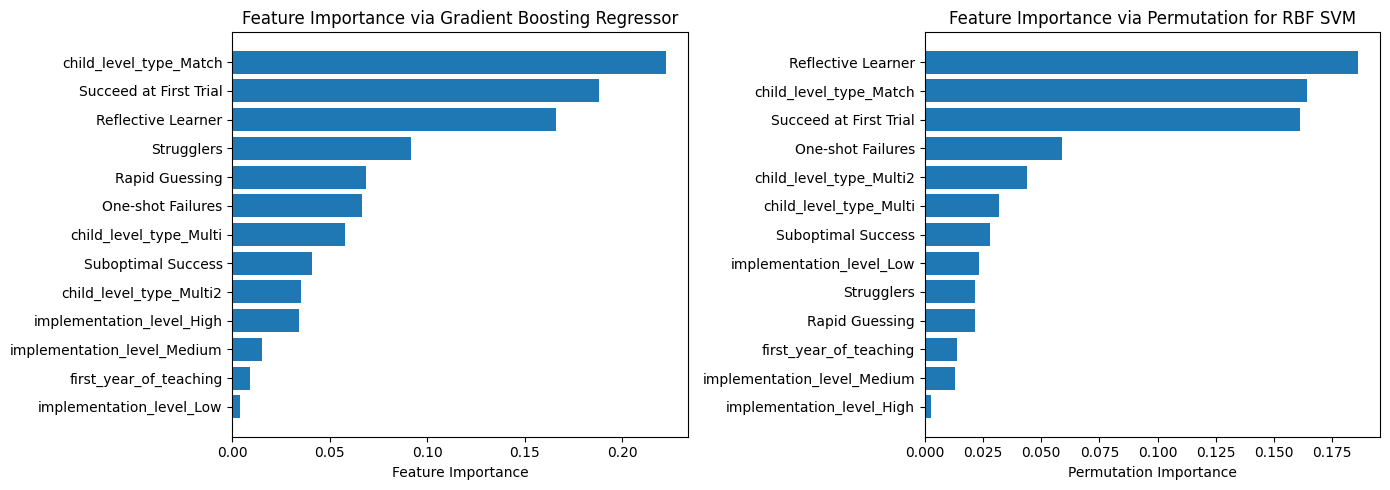

In [87]:
# Visualize feature importance for Gradient Boosting Regressor
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sorted_idx_gbr = gbm_feature_importance.argsort()
plt.barh(X.columns[sorted_idx_gbr], gbm_feature_importance[sorted_idx_gbr])
plt.xlabel("Feature Importance")
plt.title("Feature Importance via Gradient Boosting Regressor")

plt.subplot(1, 2, 2)
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation for RBF SVM")

plt.tight_layout()
plt.show()

### Visualizing Gradient Boosting Importance: SHAP

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance and effects, taking into account the interaction effects among features. It gives a value for each feature for each prediction, indicating the direction and magnitude of the feature's effect.

In [76]:
# Compute SHAP values for Gradient Boosting Regressor
explainer_gbm = shap.TreeExplainer(gbm_reg)
shap_values_gbm = explainer_gbm.shap_values(X_train)

shap_values_gbm

array([[-0.00246   , -0.07297301,  0.00959309, ..., -0.03896769,
         0.01029837,  0.0070149 ],
       [-0.00348033, -0.01293709,  0.01283022, ..., -0.06985797,
        -0.10261283, -0.10205683],
       [-0.00348033, -0.01670614, -0.00130648, ..., -0.04115582,
         0.01350352,  0.00995538],
       ...,
       [-0.00246   , -0.00468932,  0.01289146, ..., -0.05215143,
         0.01204603,  0.00890268],
       [-0.00296803, -0.0086628 ,  0.01064341, ..., -0.05749316,
         0.01273758,  0.01035887],
       [ 0.00157379, -0.03418947, -0.04781907, ..., -0.04972869,
         0.01171637,  0.00649308]])

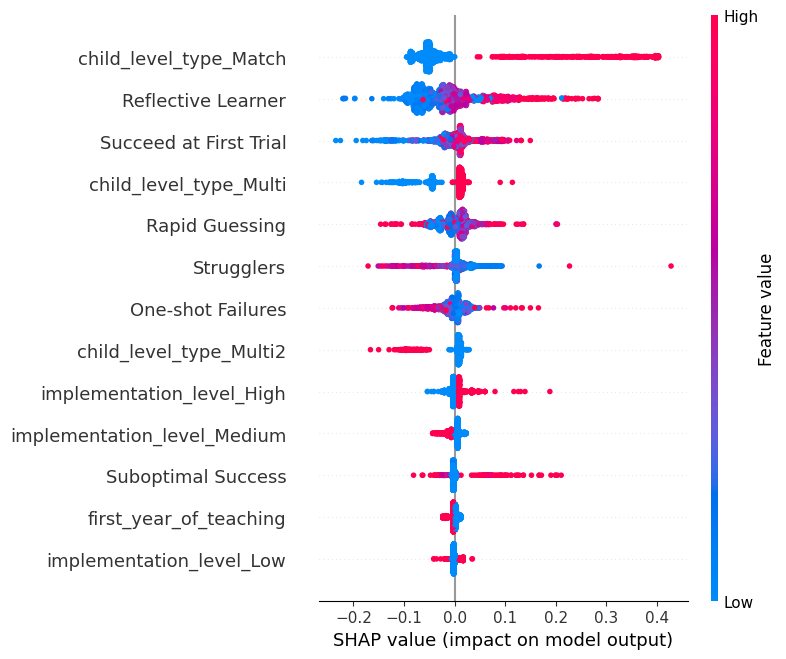

In [77]:
shap.summary_plot(shap_values_gbm, X_train)

**Vertical Axis**: Each row on the y-axis corresponds to a feature in the dataset.
Features at the top are the most influential, with significance decreasing as you move downwards.

**Horizontal Axis**: Represents the SHAP value for each feature. The further a dot is from the center, the greater its impact on the prediction.
Right of Center (positive values): Features that push the prediction higher.
Left of Center (negative values): Features that push the prediction lower.

**Color**: The color intensity signifies the magnitude of the feature value.
Red Dots: High feature values. For example, <u> red dots on the right suggests that high values of this feature increase the assessment scores </u>.
Blue Dots: Low feature values. For example, <u> blue dots on the right suggests that low values of this feature increase the assessment scores </u>.

A mix of red and blue dots spread across both sides indicates that the feature can either increase or decrease the prediction, depending on its value and potential interactions with other features. For instance, both very high and very low values of a feature might increase the prediction, while mid-range values decrease it.

### Visualizing SVM Importance: Partial Dependence Plots

These plots show the relationship between a feature and the predicted outcome while keeping all other features constant. They provide insight into the direction and strength of the relationship between the features and the prediction.

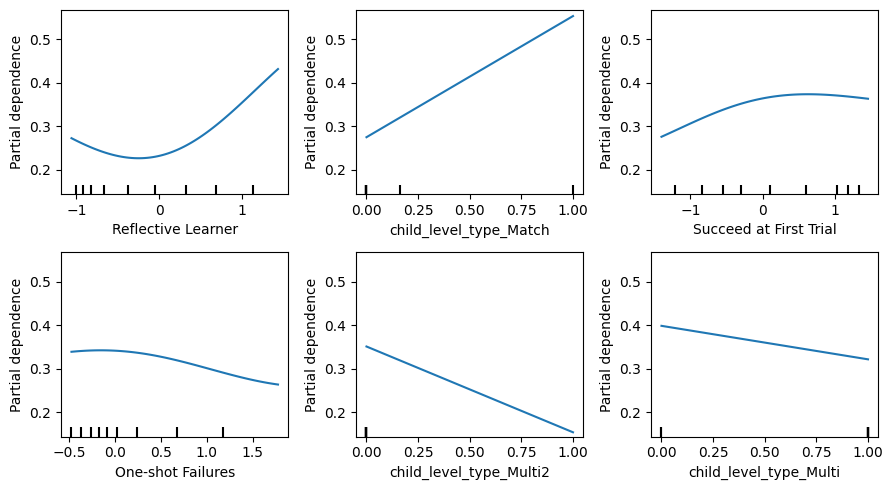

In [80]:
from sklearn.inspection import PartialDependenceDisplay

# Generate the partial dependence display object with the 3x2 layout for the top 6 important features
top_features = sorted_idx[-6:]
# Reverse the order of the top_features list
top_features = top_features[::-1]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
ax = ax.ravel()

display = PartialDependenceDisplay.from_estimator(svr_reg, X_train, top_features, grid_resolution=80, ax=ax)
plt.tight_layout()
plt.show()

**Flat Line**:
Indicates the feature has little to no effect on the prediction when other variables are held constant.

**Sloping Line (Upward/Downward)**:
Indicates a positive/negative relationship between the feature and the outcome.
Positive Slope: As the feature's value increases, the predicted outcome also increases.
Negative Slope: As the feature's value increases, the predicted outcome decreases.

**Curved Line**:
Indicates a non-linear relationship. The feature might have increasing effects up to a point and decreasing effects afterward, or vice-versa.

## Conclusion

`````{admonition} Insights
:class: tip

1. **Dominance of Question Types**: 
    * The predominant role of question types is evident, with 'matching' and 'single choice' emerging as strong positive predictors of scores. This aligns with finding from assessment section where matching question is the easiest type of question, followed by single-choice question.

2. **Student Learning Profiles Matter**: 
    * Beyond the inherent question type, it's evident that a student's daily activity engagement patterns can predict their assessment scores. The profiles 'reflective learner' and 'succeed at first trial' are positively associated with assessment scores. This underscores the value of consistent engagement and the ability to grasp concepts quickly.

3. **Concerning Learning Patterns**: 
    * In contrast, the 'struggler' profile negatively correlates with performance, indicating that persistent challenges grasping material associate with poorer outcomes. Targeted support may help remediate these learner needs.

4. **Potential Misconceptions Addressed**: 
    * Interestingly, patterns like 'one-shot failure' and 'rapid guessing' don't show a significant association with assessment scores in the SVM model. Rapid guessing and one-shot failures, often seen as red flags, might not always signify poor understanding or performance. It's possible that in some contexts, these patterns might represent a strategic approach to learning or testing. Further investigation is needed to explore the nuances of these behaviors.

`````

## Key Insights:

- **Re-examining Question Design**: 
    * The strong influence of certain question types signals the need to carefully evaluate assessment question design. Educators should ensure assessments include a strategic mix of question types that avoids potential biases and accurately measures comprehension of learning objectives.

- **Teacher Development**: 
    * Training on strategies to recognize learning profiles, personalize instruction, design objective assessments, and avoid biased evaluations based on assumptions could empower teachers. This suggests the need for nuanced approaches to assess and categorize learners' behaviors.

- **Personalized Learning Interventions**: 
    * Recognizing the distinct learning profiles and their influence on assessments can lead to more personalized and effective learning interventions. For instance, providing additional resources or tailored learning pathways for 'strugglers' could enhance their understanding and performance. Providing targeted support, resources, and interventions based on each student's learning patterns could help struggling students while optimizing outcomes for all.

- **Challenging Traditional Notions**: 
    * The lack of significant association between certain patterns (like rapid guessing) and assessment scores underscores the importance of not hastily categorizing students based on isolated behaviors.